## 1. 引言

前面我们已经通过[预训练](https://golfxiao.blog.csdn.net/article/details/144872558)让模型学会了如何基于给定的序列来预测下一个词，通过[SFT之指令微调](https://golfxiao.blog.csdn.net/article/details/145121815)让模型学会了如何遵循人类指令。这个模型在推理时存在一个不足，它每次都是选择可能性最大的词来作为next token，这种单一的选词策略会使得生成的回复显得单调，缺乏多样性和创造性。

本文我们将会引入一些更为灵活的解码策略，例如：温度采样、top-k采样，来提高模型生成文本的整体质量。

## 2. 解码策略

所谓的解码策略，就是通过不同的概率计算和选词算法，来控制模型生成文本的随机性和多样性，常见的策略有：
- argmax：最高概率采样
- multiomia：随机概率采样
- 温度缩放
- top-k采样

#### 2.1 随机概率选词
在这之前，我们总是使用`torch. argmax`对概率最高的token进行采样作为下一个词。为了增加多样性，我们可以使用`torch.multiomia(props，num_samples=1)`方法对下一个token进行采样，在这个算法中，每个词被选中的机会对应于它在输入张量中的概率。

下面我们有一个非常小的词汇表来演示选词算法的整个过程，其中vocab和inverse_vocab分别表示编码表和解码表。

In [25]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 
inverse_vocab = {v: k for k, v in vocab.items()}
inverse_vocab

{0: 'closer',
 1: 'every',
 2: 'effort',
 3: 'forward',
 4: 'inches',
 5: 'moves',
 6: 'pizza',
 7: 'toward',
 8: 'you'}

假设输入是"every effort moves you"，LLM推理得到的`next token`的logits是下面的数值。

In [26]:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

有了上面的数据，我们可以用softmax算法得到这些代表可能性大小的logits所对应的概率`probas`。

In [27]:
probas = torch.softmax(next_token_logits, dim=0)
torch.set_printoptions(precision=5, sci_mode=False)
probas

tensor([    0.06091,     0.00163,     0.00010,     0.57212,     0.00342,
            0.00013,     0.00010,     0.35758,     0.00401])

> 注：上面的set_printoptions用于设置print函数的打印方式，其中precision选项控制了输出的数值精度为 5 位小数，sci_mode选项则用于关闭科学计数表示法。

如果用之前的最大概率算法进行选词，则下一个生成token会是`forward`。

In [14]:
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

forward


并且不论上面这段选词代码运行多少次，结果都会是`forward`，因为argmax算法只选概率最大的词，而上面logits中概率最大的词只有一个。

但是如果我们使用`torch.multinomial`算法来选词，得到的词会与上面不一样。
> 注：torch.multinomial会按照softmax计算出的概率分布来随机加权采样，这意味着每个词被选中的几率与它对应的概率大小成正比，num_samples=1表示只采样一个token。
> item()用于从pytorch张量中获取标量值，只适用于张量中仅有单个元素的情况。

In [15]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

toward


如果我们运行10次，可以发现，概率大的词被选择的次数更多，同时概率小的词也有被选择的机会。

In [23]:
torch.manual_seed(123)
for i in range(10):
    next_token_id = torch.multinomial(probas, num_samples=1).item()
    print(f"No.{i+1}:{inverse_vocab[next_token_id]}")

No.1:toward
No.2:forward
No.3:toward
No.4:forward
No.5:forward
No.6:you
No.7:forward
No.8:forward
No.9:forward
No.10:closer


下面让我们将**运行次数扩展到一万次**，并对所有采样得到的数据进行分类统计，看看采样结果的分布有什么规律。
> `torch.bincount`用于对采样结果进行计数，它会生成一个张量，显示每个token_id索引(i)在sample中出现的次数(freq)。

In [24]:
def print_sampled_tokens(probas, n=1):
    torch.manual_seed(123) # Manual seed for reproducibility
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(n)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{inverse_vocab[i]} --> {freq}")

print_sampled_tokens(probas, 10000)

closer --> 641
every --> 12
effort --> 0
forward --> 5746
inches --> 39
moves --> 5
pizza --> 0
toward --> 3523
you --> 34


通过上面的统计结果可以看到，当运行的采样次数足够多时，`torch.multinomial`函数采样的结果会非常接近`softmax`算法得到的概率分布。

这个按照概率随机选词的方法（torch.multinomial）已经引入了多样性，不过它还无法自由控制多样性的程度，就像我们使用chatgpt时在某些严谨的场景中希望让模型回答要严谨和准确，而在另外一些场景中希望模型的回答更具有创造性。要实现这样灵活的控制，我们需要引入`温度缩放`。

#### 2.2 温度缩放

**温度缩放**是指在计算概率分布时先将 logits（表示可能性数值） 除以大于 0 的数字，再应用softmax函数得到概率分布。温度的作用在于可以通过改变温度值来改变概率分布，其中：
- 温度大于1时，将使各个token之间的概率分布值更加平滑，原来概率大的值将会适当减小，而概率小的值将会适当变大，相当于增加了较低概率词的选择可能性； 
- 温度小于1时，将使各个token之间的概率分布值更加尖锐，原来概率大的值将会更大，这意味着结果将更具有确定性；

下面让我们实现一个支持温度缩放的softmax函数。

In [ ]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

为了示例这个函数的效果，我们我们定义三个不同的温度值，并计算对应的概率分布。
- 1：正常温度，表示没有调整。
- 0.1：较低的温度，输出将更集中在高概率词附近。
- 5：较高的温度，输出将更分散，可能包含更多低概率词。

In [26]:
temperatures = [1, 0.1, 5] 
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]
scaled_probas

[tensor([    0.06091,     0.00163,     0.00010,     0.57212,     0.00342,
             0.00013,     0.00010,     0.35758,     0.00401]),
 tensor([    0.00000,     0.00000,     0.00000,     0.99099,     0.00000,
             0.00000,     0.00000,     0.00901,     0.00000]),
 tensor([0.15465, 0.07497, 0.04291, 0.24205, 0.08693, 0.04538, 0.04300, 0.22034,
         0.08976])]

上面得到了分别用三个温度缩放后的概率分布，但数字有些多看起来不够直观，我们用matplotlib来绘制三个概率分布的柱状图表示。

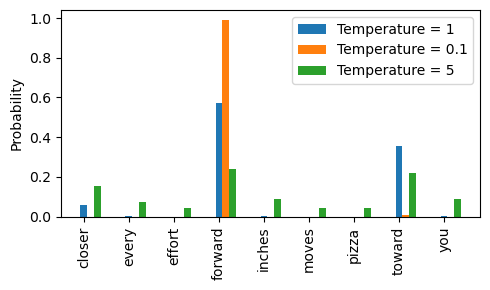

In [28]:
import matplotlib.pyplot as plt
# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.show()

通过图示我们可以看到，相对于默认的`温度=1`的概率分布（上图中蓝色表示），其它两个温度对概率分布的影响如下：
- 通过温度=`0.1` 的重新缩放后，概率呈现更加清晰（或尖锐）的分布，`forward`这个词几乎总是被选中，接近于 `torch.argmax`函数的效果；
- 通过温度=`5` 的重新缩放后，概率呈现更加平坦的分布，其中`forward`和`toward`的概率最高，但其它词`closer`、`every`、`effort`、`inches`、`moves`、`pizza`、`you`也柱状图上也呈现出一定的概率分布。


> 注：从上面温度对概率分布的影响可以看出，温度如果持续升高，高可能性词和低可能性词的概率值将趋近于相同，这意味着模型输出将接近完全随机，等于回到了预训练之前，这肯定不是我们想要的，所以实际场景中，温度调整范围会限定在一个有效的区间内，像ChatGPT的**温度有效区间**就是`0-2`。


#### 2.3 topK

上面我们引入温度缩放获得了对模型输出多样性的自由控制，但放到实际应用中仍然会有一些潜在的问题，例如：
在使用更高温度提高多样性时，模型偶尔会输出一些罕见且低质量的词，导致生成文本的整体效果变差。
> 原因在于: 每次推理时词表中的所有词都是有效值，虽然低可能性词的概率很低，但这些词仍然有一定的几率被选中，一旦被选中就会加入到序列上下文中影响后续token的预测，导致模型会生成一些奇奇怪怪不着边际的内容。

为了能够使用更高的温度来增加输出多样性并减少无意义句子的概率，我们可以将采样的标记限制为 top-k 个最有可能的标记。

In [29]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)

print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.75000, 6.28000, 4.51000])
Top positions: tensor([3, 7, 0])


> 在上面的例子中，我们使用了top 3, 9个词中只有可能性最高的前3个词`forward`、`toward`、`closer`是有效的。

接下来要做的是，将上面三个词的logits值保留，其它位置的都置为`-inf`，目的是在随后的softmax环节只计算这三个词的概率分布。

In [31]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float("-inf")), 
    other=next_token_logits
)
print(new_logits)

tensor([4.51000,    -inf,    -inf, 6.75000,    -inf,    -inf,    -inf, 6.28000,
           -inf])


> torch.where的释义如下：
> - condition: 用于找出比4.51000（上面3个logits中的最小值）小的所有元素； 
> - input: 满足condition条件的元素将被替换为`-inf`； 
> - other: 当condition不满足时，则保留next_token_logits中的原始值； 

对这个new_logits重新计算概率分布。

In [32]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.06148, 0.00000, 0.00000, 0.57755, 0.00000, 0.00000, 0.00000, 0.36097,
        0.00000])


可以看到，只有3、7、0这三个位置的概率有效，其它位置概率均为0。

## 3. 解码策略应用

#### 3.1 生成函数改造
首先，将上面的`top_k`算法封装为一个独立的top_k采样函数。

In [42]:
def top_k_sampling(next_token_logits, top_k):
    top_logits, top_pos = torch.topk(next_token_logits, top_k)
    min_val = top_logits[:, -1]
    new_logits = torch.where(
        condition=next_token_logits < min_val,
        input=torch.tensor(float("-inf")).to(next_token_logits.device),
        other=next_token_logits,
    )
    return new_logits

再将`温度缩放`策略封装为一个独立的温度采样函数，在这个函数中分为两种情况：
1. 温度大于0，需要根据温度大小缩放，走随机概率来选择下一个token；
2. 温度等于0，还和之前一样，固定取概率最大的词作为下一个token；

In [43]:
def temperature_sampling(next_token_logits, temperature):
    if temperature > 0.0:
        logits = next_token_logits / temperature
        probs = torch.softmax(logits, dim=-1)  
        next_token_ids = torch.multinomial(probs, num_samples=1)
    else:
        probs = torch.softmax(next_token_logits, dim=-1)
        next_token_ids = torch.argmax(probs, dim=-1, keepdim=True)  
    return next_token_ids

导入MiniGPT的模型结构代码，并基于上面两个新的选词策略来封装一个v2版本的generate函数。

In [44]:
%run transformer.py

In [45]:
def generate_v2(self, input_ids, max_length=512, eos_token_id=-1, temperature=0.0, top_k=None, **kwargs):
    assert isinstance(max_length, int) and max_length > 0
    eos_reached = torch.zeros(len(input_ids), dtype=torch.bool, device=input_ids.device)
    
    for _ in range(max_length):
        # 超出上下文长度时，截取最后的context_length个token
        context_ids = input_ids[:, -self.context_length:]  
        with torch.no_grad():
            output = self(context_ids, **kwargs)  # shape: batch, n_tokens, vocab_size
        # 只取每个序列最后一个token的输出向量作为logits, shape变为: batch, vocab_size
        next_token_logits = output[:, -1, :]  
        # New: top_k采样
        if top_k is not None:
            next_token_logits = top_k_sampling(next_token_logits, top_k)
        # New: 温度采样
        next_token_ids = temperature_sampling(next_token_logits, temperature)
        # 将next_token_id连接到每个序列的结尾，形状变为：batch, n_tokens+1
        input_ids = torch.cat((input_ids, next_token_ids), dim=1)
        # 判断是否所有序列都结束
        eos_reached |= (next_token_ids.squeeze(-1) == eos_token_id)
        if eos_reached.all(): break

    return input_ids

setattr(MiniGPT, "generate_v2", generate_v2)

#### 3.2 生成文本测试

首先，基于上一节[SFT之指令微调](https://golfxiao.blog.csdn.net/article/details/145121815)训练的权重参数来加载模型状态。

In [46]:
device='cuda:2'
model = MiniGPT(GPTConfig()).to(device)
sft_checkpoint_path = "/data2/minigpt/models/sft/20241020/checkpoint-330000.pth"
sft_checkpoint = torch.load(sft_checkpoint_path, map_location=device, weights_only=False)
model.load_state_dict(sft_checkpoint['model_state'])

<All keys matched successfully>

加载分词器，并封装两个编码和解码方法，用于人类文本和token_id序列之间的转换。

In [34]:
tokenizer_path = "/data2/minigpt/models/tokenizer_v3"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path, use_fast=False)

In [56]:
def encode(tokenizer, prompt):
    messages = [{"role": "user", "content": instruction}]
    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    return torch.tensor([tokenizer.encode(prompt)])

def decode(tokenizer, token_ids):
    return tokenizer.decode(token_ids, skip_special_tokens=True)

将`encode`、`generate_v2`、`decode`三个方法串在一起，就构成了一个文本推理方法。

In [57]:
def predict(model, tokenizer, prompt, device, max_new_tokens=128, temperature=0.0, top_k=None):
    inputs = encode(tokenizer, prompt).to(device)
    response_ids = model.generate_v2(inputs, max_new_tokens, tokenizer.eos_token_id, temperature, top_k)
    response_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs, response_ids)
    ]
    return decode(tokenizer, response_ids[0])

下面，我们来看下不同温度和top_k参数所带来的文本生成效果。

1. 不使用温度缩放和top-k算法。

In [61]:
instruction = "请介绍下什么是AI？"
predict(model, tokenizer, instruction, device, 128, 0.0, None)

'AI（人工智能）是一种模拟人类智能的技术，它使计算机系统能够像人类一样思考、学习、推理、解决问题和做出决策。AI可以被视为一种技术，它可以让计算机系统执行复杂的任务，例如语音识别、图像识别、自然语言处理、智能推荐、自动驾驶等。AI的应用范围非常广泛，包括医疗保健、金融、制造业、交通、教育、交通等各个领域。'

2. 设定温度为0.7，top_k为10。

In [72]:
predict(model, tokenizer, instruction, device, 128, 0.7, 20)

'AI（人工智能）是一种技术，其目的是开发一种能够模拟人类智能的智能系统，这些系统可以自主思考、学习和决策。AI可以通过机器学习、深度学习和其他算法实现，从而使计算机能够处理类似于人类的思维和行为，并自动执行某些任务。AI已经广泛应用于许多领域，包括医疗保健、金融、交通、教育和制造业等。AI的发展前景非常广阔，可以为人类带来许多便利和好处，但也有一些人担心AI会取代人类，导致失业率上升等问题。'

3. 设定温度为2.0，top_k为20。

In [64]:
predict(model, tokenizer, instruction, device, 128, 2.0, 20)

'AI(人工智能技术)是现代世界范围内最为先进的技术手段，它是基于计算机模拟人类大脑的技术。它涉及了计算机科学、哲学、心理学等多个领域的研究，以改善人类的生产力和生活质量等为主要目的。例如，人工智能可以帮助机器模拟认知和行为，使其能够处理复杂的问题，并从数据中获取有价值的信息和数据。AI应用在医疗健康、智能驾驶、智能金融、智能交通等领域有着很大的发展优势。然而，随着AI技术的日益发展和AI应用的普及和深入探索越来越多，人们对于如何利用 AI 的同时保持道德和隐私问题提出了更高的需求。总之AI是目前在科技领域广泛应用的前沿技术领域所涉及的核心技术。'

可以看到，随着温度从0到2的变化，模型生成的文本变得越来越丰富。

**小结**：本文主要介绍了大语言模型在生成文本时常用的几种解码策略，multiomia用于按照概率随机采样，temperature用于控制生成文本的多样性和创造性，top_k用于规避掉低质量的token，这些解码策略可以相互结合使用。在实际应用中，可以根据具体需求灵活调整这些参数，将有助于生成更符合预期的文本内容。